In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')

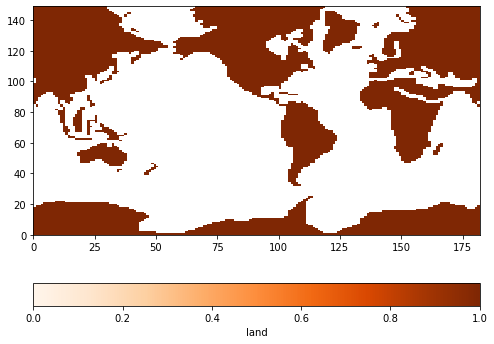

In [9]:
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tland = (tnc['tmask'][0,0,:,:])
tland = tland.astype(float)
tland[tland==1]=3
tland[tland==0]=1
tland[tland==3]=np.nan
tcmap = 'Oranges'
fact = 0.4
fig, axs = plt.subplots(1,1, figsize=(20*fact, 15*fact), facecolor='w', edgecolor='k')
pltmesh = axs.pcolormesh(tland, cmap = tcmap, vmin = 0, vmax = 1)
fig.colorbar(pltmesh, ax=axs, orientation = 'horizontal', label = 'land')

(12, 149, 182)
7.389119e-07
3.51236e-07


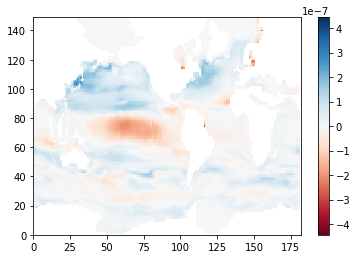

In [19]:

yearstart = 1965
baseDir = '/gpfs/data/greenocean/software/runs/'
yr = 1970
filepat = 'diad_T'
trun = 'TOM12_TJ_M001'
var = 'Cflx'

w = glob.glob(f'{baseDir}{trun}/*{yr}*{filepat}.nc')
ncnam = (w[0])

tnc = nc.Dataset(ncnam)

cflx = (tnc[var][:])
print(np.shape(cflx))
flxout = (np.nanmax(cflx))
flxin = (np.abs(np.nanmin(cflx)))
cflx[cflx == 0 ] = np.nan
print(flxin)
print(flxout)
cbarmax = (np.max([flxout,flxin]))
w = plt.pcolormesh(cflx[11,:,:], cmap = 'RdBu', vmin = -0.6*cbarmax, vmax = 0.6*cbarmax)
plt.colorbar(w)

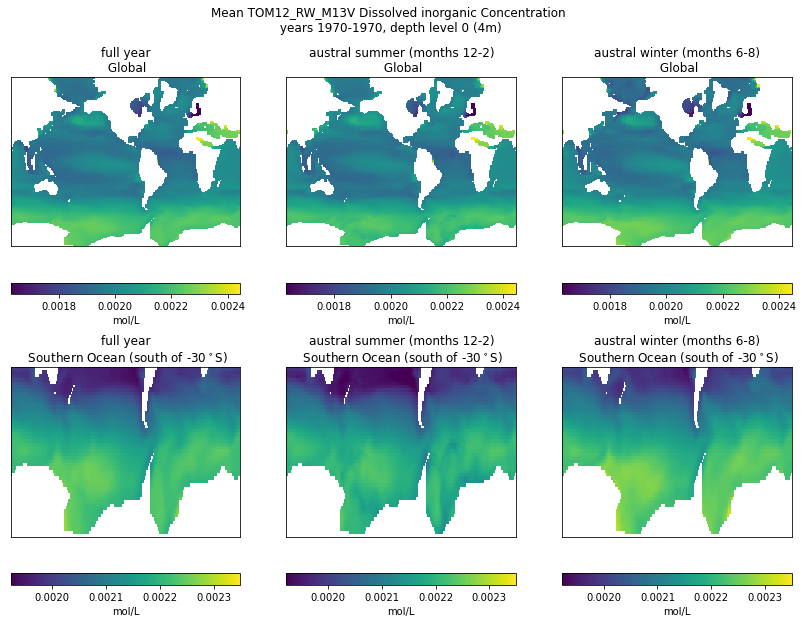

In [113]:
modname = 'TOM12_RW_M13V'
yearstart = 1970
yearend = 1970
ncstr = 'ptrc_T'
var = 'DIC'
depthind = 0
#we assume that model output is in this directory tree
baseDir = '/gpfs/data/greenocean/software/runs/'


#access first file in timeseries, get out units 
w = glob.glob(f'{baseDir}{modname}/*{yearstart}*{ncstr}.nc')
ncnam = (w[0])
tnc = nc.Dataset(ncnam)
longname = tnc[var].long_name
units = tnc[var].units

### access depth 
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tdepths = (tnc['gdept_1d'][0,:])
t_depth = tdepths[depthind]
#prepare array of years to loop through, and storage arrays for output
# and for max and min for plotting
yrs = np.arange(yearstart,yearend+1,1)
noyrs = len(yrs)

summer_stor = np.zeros([noyrs,149,182])
winter_stor = np.zeros([noyrs,149,182])
allyear_stor = np.zeros([noyrs,149,182])

plt_min = 0; plt_max = 0

for y in range(0,noyrs):
    
    ts_index = 0
    yr = yrs[y]
    #find relevant nc using wildcards and the glob package
    w = glob.glob(f'{baseDir}{modname}/*{yr}*{ncstr}.nc')
    ncnam = (w[0])
    
    #open dataset and extract relevant variable 
    tnc = nc.Dataset(ncnam)
    tvar0 = tnc[var][:]
    ## if array is 4 dimensional (Time, depth, y, x), slice to get relevant depth
    #else it should be 3dimensional and you just take whole array
    if (tvar0.ndim == 4):
        tvar = tvar0[:,depthind,:,:]
    else:
        tvar = tvar0[:]
    #set up some rough mins, maxs for for colourbar  
    tvar[tvar == 0] = np.nan
    #get out summer, ie months december, jan, feb, and average accross months
    this_summer = np.zeros([3,149,182])
    this_summer[0,:,:] = tvar[11,:,:]
    this_summer[1:3,:,:] = tvar[0:2,:,:]
    ## average accross the 3 months and put into storage array
    summer_stor[y,:,:] = np.nanmean(this_summer,axis = 0)
    #winter is months 6-8, so python indices 5-8 (8 isn't counted in python indexing here)
    winter_stor[y,:,:] = np.nanmean(tvar[5:8,:,:],axis = 0)
    allyear_stor[y,:,:] = np.nanmean(tvar[:,:,:],axis = 0)
    
## average out the stored arrays
winter_stor_mn = np.nanmean(winter_stor,axis =0)
summer_stor_mn = np.nanmean(summer_stor,axis =0)
allyear_stor_mn = np.nanmean(allyear_stor,axis =0)
plt_min = 0.8*np.nanmean(allyear_stor_mn)
plt_max = 1.2*np.nanmean(allyear_stor_mn)
# get only the SO
winter_stor_mn_SO = winter_stor_mn[0:50,:]
summer_stor_mn_SO = summer_stor_mn[0:50,:]
allyear_stor_mn_SO = allyear_stor_mn[0:50,:]
plt_min_SO = 0.9*np.nanmean(allyear_stor_mn_SO)
plt_max_SO = 1.1*np.nanmean(allyear_stor_mn_SO)

to_plt = [allyear_stor_mn, summer_stor_mn, winter_stor_mn,\
         allyear_stor_mn_SO, summer_stor_mn_SO, winter_stor_mn_SO]
seas = ['full year', 'austral summer (months 12-2)', 'austral winter (months 6-8)',\
       'full year', 'austral summer (months 12-2)', 'austral winter (months 6-8)',]
fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,3):
    pltmesh = axs[i].pcolormesh(to_plt[i], cmap = 'viridis', vmin = plt_min, vmax = plt_max)
    fig.colorbar(pltmesh, ax=axs[i], orientation = 'horizontal', label = units)
    axs[i].set_yticks([]); axs[i].set_xticks([]);
    axs[i].set_title(f'{seas[i]}\n Global')
    
for i in range(3,6):
    pltmesh = axs[i].pcolormesh(to_plt[i], cmap = 'viridis', vmin = plt_min_SO, vmax = plt_max_SO)
    fig.colorbar(pltmesh, ax=axs[i], orientation = 'horizontal', label = units)
    axs[i].set_yticks([]); axs[i].set_xticks([]);
    axs[i].set_title(f'{seas[i]}\n Southern Ocean (south of -30$^\circ$S)')

plt.suptitle(f'Mean {modname} {longname}\n years {yearstart}-{yearend}, depth level {depthind} ({int(t_depth)}m)')
fig.savefig(f'{modname}_{var}_{yearstart}-{yearend}_level{depthind}.jpg')

In [76]:
print(np.shape(tvar))
print(tvar[0,:,50])

(12, 149, 182)
[0.         0.00220094 0.00220255 0.00220414 0.00220398 0.00220164
 0.00219873 0.00219603 0.00219429 0.0021934  0.00218969 0.00218298
 0.00217424 0.00217109 0.00217367 0.0021835  0.00219362 0.00220588
 0.00221526 0.00221372 0.00219308 0.00216876 0.00217299 0.0021786
 0.00217875 0.00217546 0.00217279 0.00217165 0.00217168 0.00217027
 0.00216645 0.00215976 0.00215042 0.00214013 0.00213028 0.00212021
 0.00210706 0.00208606 0.00205579 0.00201942 0.0019914  0.00197392
 0.00195375 0.00195233 0.         0.00195176 0.0019368  0.00192899
 0.00193202 0.0019431  0.0019594  0.00196179 0.00195564 0.00194614
 0.00193692 0.0019293  0.00192257 0.00191858 0.00191125 0.00190444
 0.00190412 0.00190707 0.00191006 0.00191166 0.00191174 0.00191273
 0.00191671 0.00192291 0.0019318  0.00194185 0.00195245 0.00196404
 0.00197528 0.0019839  0.0019895  0.0019925  0.00199404 0.00199329
 0.00198677 0.00197474 0.00196126 0.00194848 0.00193723 0.00192946
 0.00192564 0.0019255  0.00192685 0.00192928 0.0

In [21]:
w = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/ORCA2_1m_19700101_19701231_diad_T.nc')
print(w['Cflx'])

<class 'netCDF4._netCDF4.Variable'>
float32 Cflx(time_counter, y, x)
    long_name: 
    units: mol/m2/s
    online_operation: average
    interval_operation: 5760 s
    interval_write: 1 month
    cell_methods: time: mean (interval: 5760 s)
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lon nav_lat
unlimited dimensions: time_counter
current shape = (12, 149, 182)
filling on
